In [19]:
import pandas as pd
import re
import os

folder_path = os.path.join(os.getcwd(), 'Data', 'Raw Data')
file_list = os.listdir(folder_path)

df = pd.DataFrame()
for file in file_list:
    file_path = os.path.join(folder_path, file)
    file_df = pd.read_excel(file_path, sheet_name='Raw')
    df = pd.concat([df, file_df], ignore_index=True)

In [20]:
print(f'Starting columns: {df.shape[1]}')

#Build target columns and then remove columns needed to create
target_cols = ['Global Income Qualified 75+ CY', 'NIC MAP Occupancy - IL', 'NIC MAP Occupancy - AL', 'NIC MAP Occupancy - MC', 'Total IL Supply CY', 'Total AL Supply CY', 'Total MC Supply CY']
df = df.dropna(subset=target_cols)
df['IL Occupied Units'] = df.apply(lambda x: x['NIC MAP Occupancy - IL'] * x['Total IL Supply CY'], axis=1)
df['AL Occupied Units'] = df.apply(lambda x: x['NIC MAP Occupancy - AL'] * x['Total AL Supply CY'], axis=1)
df['MC Occupied Units'] = df.apply(lambda x: x['NIC MAP Occupancy - MC'] * x['Total MC Supply CY'], axis=1)

df['Overall Target'] = df.apply(lambda x: (x['IL Occupied Units']+x['AL Occupied Units']+x['MC Occupied Units'])/x['Global Income Qualified 75+ CY'], axis=1)
df['IL Target'] = df.apply(lambda x: x['IL Occupied Units']/x['Global Income Qualified 75+ CY'], axis=1)
df['AL Target'] = df.apply(lambda x: x['AL Occupied Units']/x['Global Income Qualified 75+ CY'], axis=1)
df['MC Target'] = df.apply(lambda x: x['MC Occupied Units']/x['Global Income Qualified 75+ CY'], axis=1)
df = df.drop(columns=target_cols+['IL Occupied Units', 'AL Occupied Units', 'MC Occupied Units'])
print(f'Columns after creating targets: {df.shape[1]}')

#Drop columns with all null values
df = df.dropna(axis=1, how='all')
print(f'Columns after removing all null: {df.shape[1]}')

#Drop columns with only one unique value
cols = df.columns.tolist()
drop_list = []
for col in cols:
    n = df[col].nunique()
    if n == 1:
        drop_list.append(col)

df = df.drop(columns=drop_list)
print(f'Columns after removing single value: {df.shape[1]}')

#Drop columns for Experian profiles
cols = df.columns.tolist()
pattern = r'^[A-Z]\d{2} '
experian_cols = [col for col in cols if re.match(pattern, col)]
df = df.drop(columns=experian_cols)
print(f'Columns after removing Experian profiles: {df.shape[1]}')

#Drop columns based on substring matches
substring_keywords = ['FY', '2010', 'Wage', 'GrowthPen', 'NC', 'Health Ins', 'Growth Rate', 'NIC', 'COLI', 'Doctors', 'Beneficiaries', 'Construction', 'Assessed', 'Supply', 'Property', 'Average Net Worth', 'Average Home Value', 'Households', 'Number of', '65+', 'Male Population']
for keyword in substring_keywords:
    cols = df.columns.tolist()
    drop_list = [col for col in cols if keyword in col]
    df = df.drop(columns=drop_list)
print(f'Columns after removing substring: {df.shape[1]}')

#Drop columns manually by name
drop_manual = ['SiteId','FacilityId','StreetAddress', 'City', 'ZipCode', 'IADL Disabled Senior Rate', 'Disabled Senior Rate', 'Median Sales Price Per Unit Last 5 Years']
df = df.drop(columns=drop_manual)
print(f'Columns after removing manual: {df.shape[1]}')

display(df.head())

Starting columns: 1278
Columns after creating targets: 1275
Columns after removing all null: 1264
Columns after removing single value: 1191
Columns after removing Experian profiles: 1049
Columns after removing substring: 392
Columns after removing manual: 384


,FacilityName,State,Latitude,Longitude,$1-$15K Income Qualified 75-84 CY,$1-$15K Income Qualified 80+ CY,$1-$15K Income Qualified 85+ CY,$100K-$125K Income Qualified 75-84 CY,$100K-$125K Income Qualified 80+ CY,$100K-$125K Income Qualified 85+ CY,...,Units In Fill AL,Units In Fill IL,Units In Fill MC,Veteran Population 55-64 CY,Veteran Population 65-74 CY,Veteran Population 75+ CY,Overall Target,IL Target,AL Target,MC Target
0,Aberdeen Village,KS,38.91481,-94.79076,358,366,234,569,339,129,...,108,117,61,1336,2597,2099,0.569617,0.280060,0.196901,0.092656
2,Brookdale Leawood State Line,KS,38.89700,-94.60876,435,529,346,514,360,144,...,54,0,0,1296,1983,2944,0.651660,0.447468,0.154815,0.049376
4,Bickford of Overland Park,KS,38.93575,-94.66350,710,867,570,868,623,260,...,54,10,11,1778,3424,4787,0.665659,0.413007,0.171936,0.080716
6,The Atriums,KS,38.93438,-94.67137,697,853,562,851,615,259,...,54,10,11,1816,3533,4810,0.652153,0.407235,0.165262,0.079656
7,Autumn Woods Inc,MO,39.19416,-94.61938,447,428,255,348,222,87,...,1,0,0,2024,2965,2656,0.397412,0.167608,0.180088,0.049716


Columns for clustering: 309


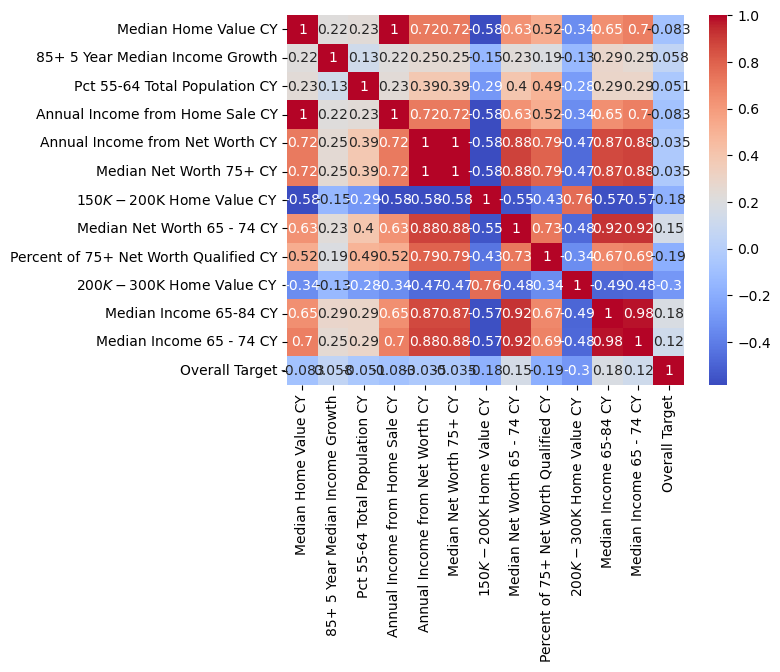

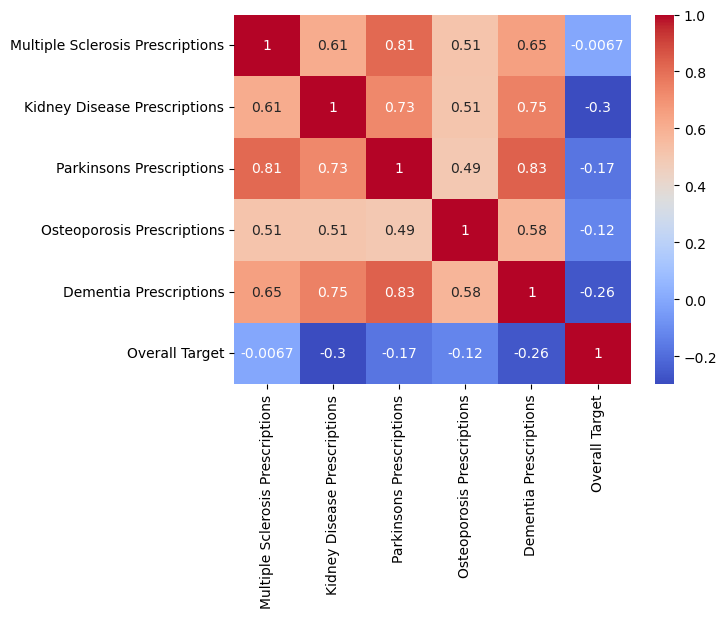

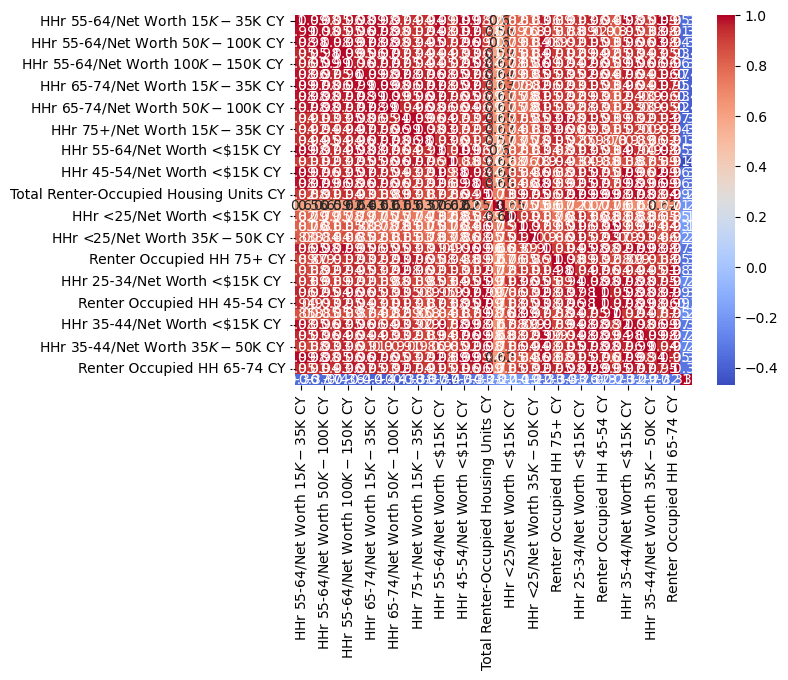

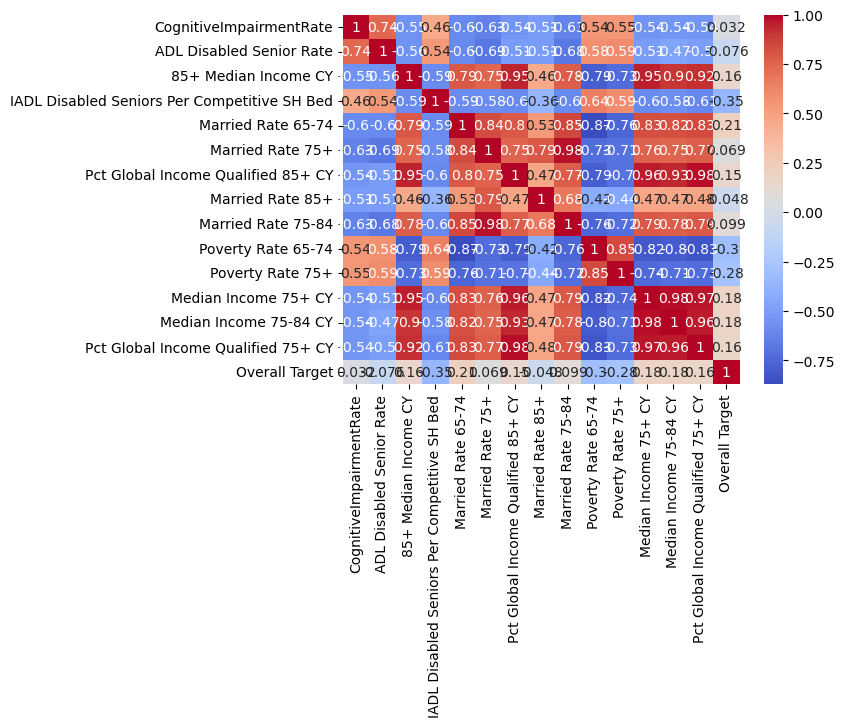

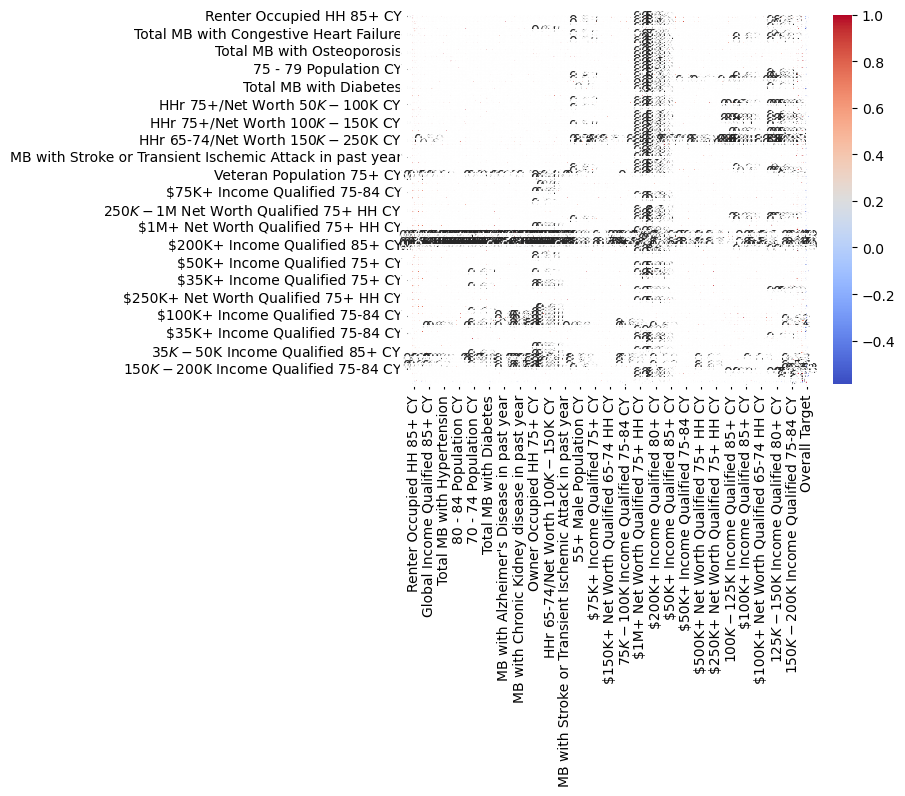

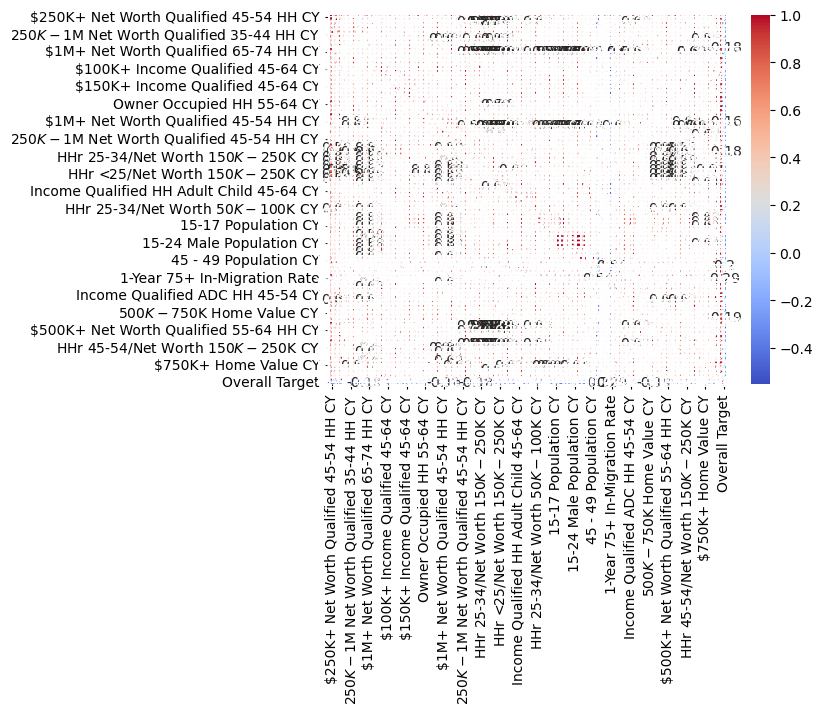

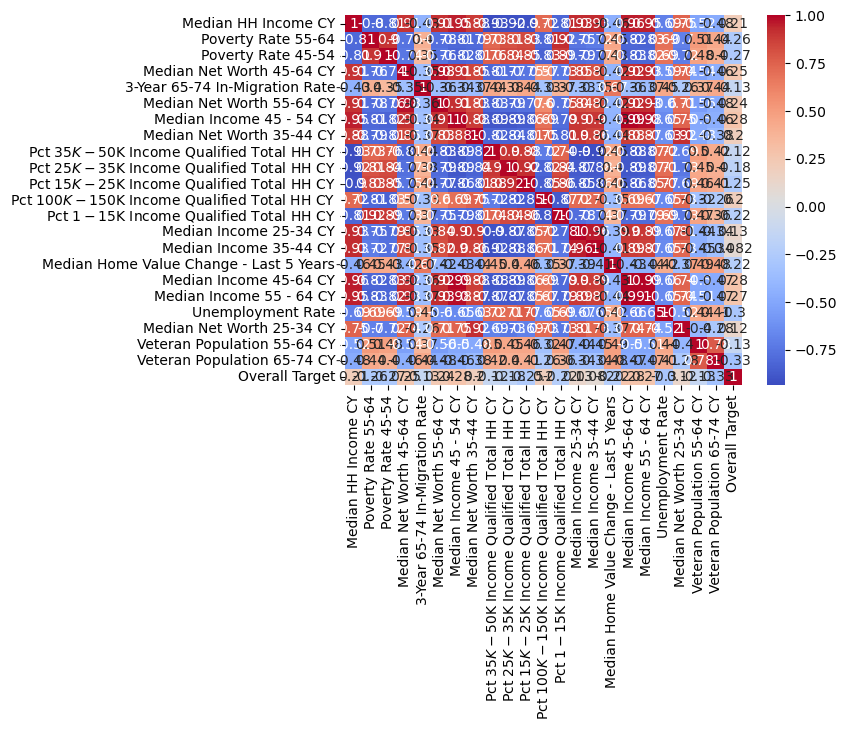

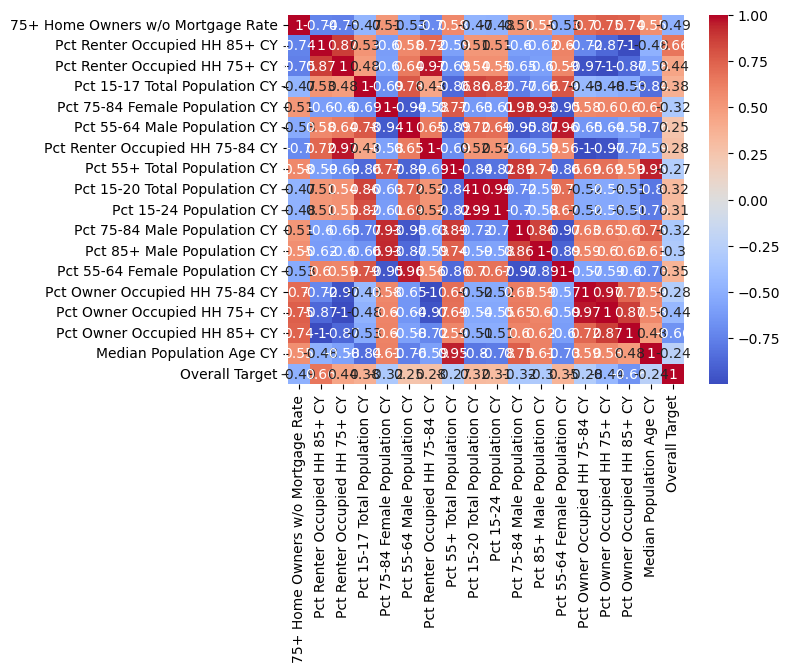

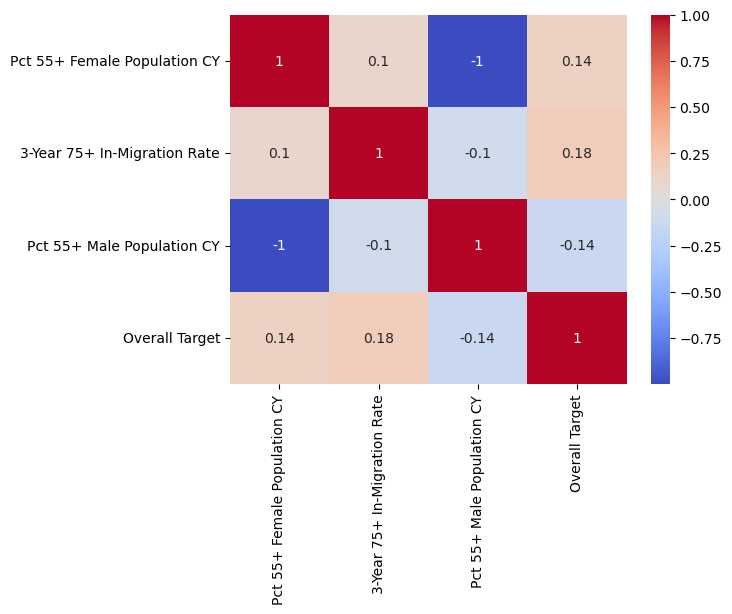

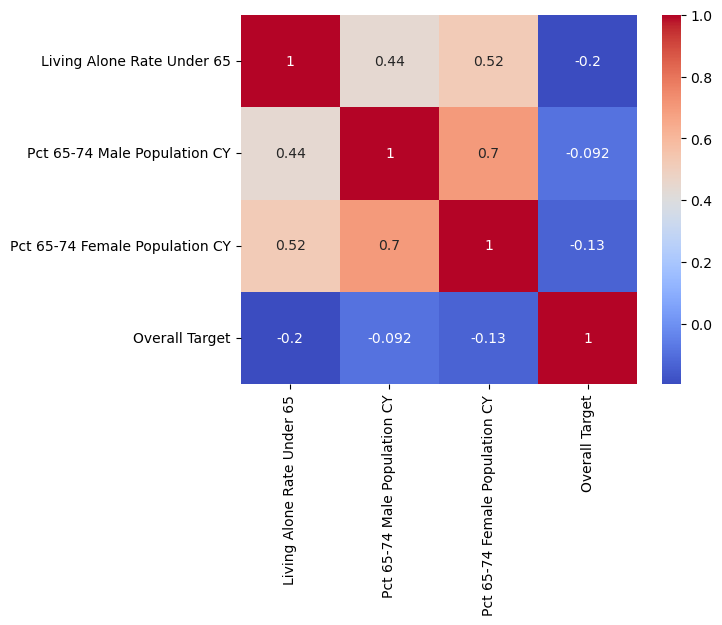

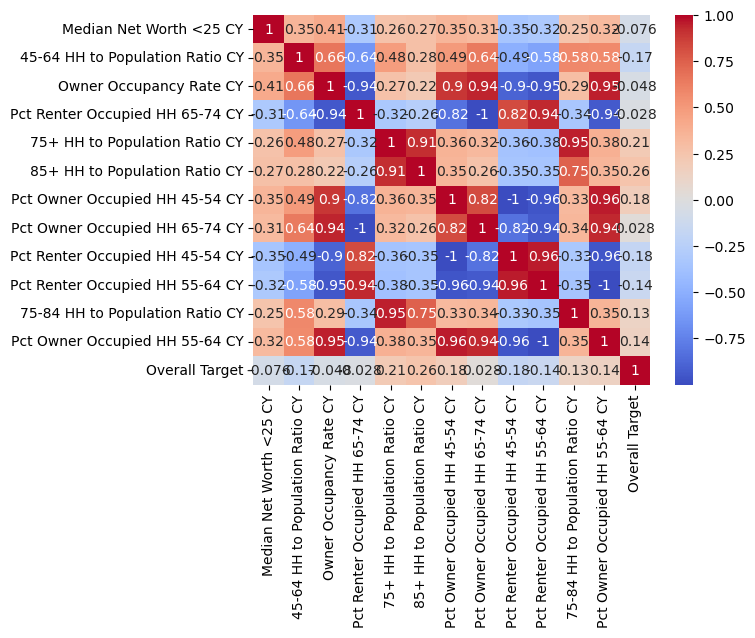

In [21]:
locs = ['IL', 'AL', 'MC', 'Active Adult', 'AA']
cluster_df = df.copy()

for loc in locs:
    cols = cluster_df .columns.tolist()
    loc_cols = [col for col in cols if loc in col]
    cluster_df  = cluster_df .drop(columns=loc_cols)

cluster_df = cluster_df.drop(columns=['FacilityName', 'State', 'Latitude', 'Longitude', 'Overall Target'])
print(f'Columns for clustering: {cluster_df .shape[1]}')

corr = cluster_df.corr()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

dissimilarity = 1 - abs(corr)
dissimilarity = np.clip(dissimilarity,0,1)
Z = linkage(squareform(dissimilarity), method='complete')
labels = fcluster(Z, 0.9, criterion='distance')


cluster_cols = cluster_df.columns
col_df = pd.DataFrame({'column':cluster_cols, 'cluster':labels}).sort_values(by='cluster')

for cluster in col_df['cluster'].unique().tolist():
    cluster_cols = col_df[col_df['cluster'] == cluster]['column'].tolist()
    cluster_df = df.loc[:,cluster_cols+['Overall Target']]
    corr = cluster_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.show()

    
